<a href="https://colab.research.google.com/github/mirchandani-mohnish/ClusterMetrics/blob/main/kmedoids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --force-reinstall numpy==1.23.5

In [2]:
!pip install scikit-learn-extra

In [4]:
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import os
import seaborn as sns
import numpy as np
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import time
from scipy.spatial.distance import cdist

In [5]:
seed = 0

In [6]:
def k_medoids(X, k, max_iter=100, tol=1e-4, metric='euclidean'):
    n = len(X)
    rng = np.random.default_rng(seed)
    medoid_indices = rng.choice(n, k, replace=False)
    medoids = X[medoid_indices]
    prev_medoids = np.zeros_like(medoids)
    labels = np.zeros(n, dtype=int)

    for _ in range(max_iter):
        # Assign each point to the nearest medoid
        distances = cdist(X, medoids, metric)
        labels = np.argmin(distances, axis=1)

        # Swap step: Try replacing medoids with non-medoids and check cost
        for i, medoid in enumerate(medoids):
            cluster_points = X[labels == i]
            best_medoid = medoid
            best_cost = np.sum(cdist(cluster_points, [medoid], metric))

            for point in cluster_points:
                cost = np.sum(cdist(cluster_points, [point], metric))
                if cost < best_cost:
                    best_medoid = point
                    best_cost = cost

            medoids[i] = best_medoid

        # Convergence check
        if np.allclose(prev_medoids, medoids, atol=tol):
            break
        prev_medoids = medoids.copy()

    return labels, medoids

In [7]:
path = kagglehub.dataset_download("himanshunakrani/iris-dataset")
iris = pd.read_csv(os.path.join(path, "iris.csv"))
iris = iris.dropna()

iris_filtered = iris.select_dtypes(include=['float64'])

X_iris = iris_filtered.to_numpy()
k_iris = 3

print("Iris Dataset\n")

start_time = time.time()
labels_base_iris, centroids_base_iris = k_medoids(X_iris, k_iris)
print(f"Execution time (base): {time.time() - start_time} seconds")
print(f"DBI score (base): {davies_bouldin_score(X_iris, labels_base_iris)}")

start_time = time.time()
kmedoids_iris = KMedoids(n_clusters=k_iris, random_state=seed).fit(X_iris)
labels_sklearn_iris = kmedoids_iris.labels_
centroids_sklearn_iris = kmedoids_iris.cluster_centers_
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print(f"DBI score (sklearn): {davies_bouldin_score(X_iris, labels_sklearn_iris)}")

100%|██████████| 0.98k/0.98k [00:00<00:00, 1.76MB/s]

Extracting files...
Iris Dataset

Execution time (base): 0.013103961944580078 seconds
DBI score (base): 0.662322864989869

Execution time (sklearn): 0.008056879043579102 seconds
DBI score (sklearn): 0.6690341629005112


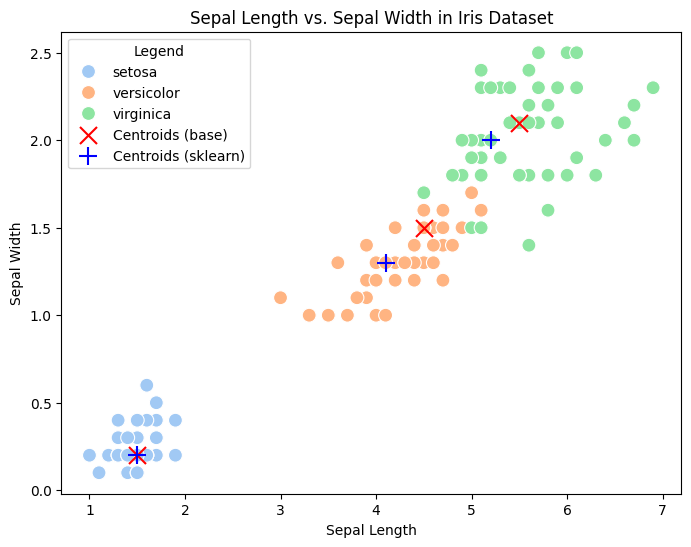

In [10]:
plength_idx = list(iris_filtered.columns).index("petal_length")
pwidth_idx = list(iris_filtered.columns).index("petal_width")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue="species", palette="pastel", s=100)
plt.scatter(centroids_base_iris[:, plength_idx], centroids_base_iris[:, pwidth_idx], c='red', marker='x', s=150, label='Centroids (base)')
plt.scatter(centroids_sklearn_iris[:, plength_idx], centroids_sklearn_iris[:, pwidth_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.title("Sepal Length vs. Sepal Width in Iris Dataset")
plt.legend(title="Legend")
plt.show()

In [11]:
from sklearn.preprocessing import OrdinalEncoder

path = kagglehub.dataset_download("katerynameleshenko/ai-index")
ai = pd.read_csv(os.path.join(path, "AI_index_db.csv"))
ai = ai.dropna()

ai["Total_score_Category"] = pd.cut(
    ai["Total score"],
    bins=[-float("inf"), 17.03, 26.91, float("inf")],
    labels=["Low", "Medium", "High"]
)
ai = ai.drop(columns=["Total score", "Country"])

ai_filtered = ai.drop(columns=["Total_score_Category"])

encoder = OrdinalEncoder()

categorical_cols = [col for col in ai_filtered.columns if ai_filtered[col].dtype not in [np.int64, np.float64]]
ai_filtered[categorical_cols] = encoder.fit_transform(ai_filtered[categorical_cols])

X_ai = ai_filtered.to_numpy()
k_ai = 3

print("AI Global Index")

start_time = time.time()
labels_base_ai, centroids_base_ai = k_medoids(X_ai, k_ai)
print(f"Execution time (base): {time.time() - start_time} seconds")
print(f"DBI score (base): {davies_bouldin_score(X_ai, labels_base_ai)}")

start_time = time.time()
k_medoids_ai = KMedoids(n_clusters=k_ai, random_state=seed).fit(X_ai)
labels_sklearn_ai = k_medoids_ai.labels_
centroids_sklearn_ai = k_medoids_ai.cluster_centers_
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print(f"DBI score (sklearn): {davies_bouldin_score(X_ai, labels_sklearn_ai)}")

100%|██████████| 2.38k/2.38k [00:00<00:00, 1.88MB/s]

Extracting files...
AI Global Index
Execution time (base): 0.00614619255065918 seconds
DBI score (base): 1.3053732530275475

Execution time (sklearn): 0.0029990673065185547 seconds
DBI score (sklearn): 1.891091791455158


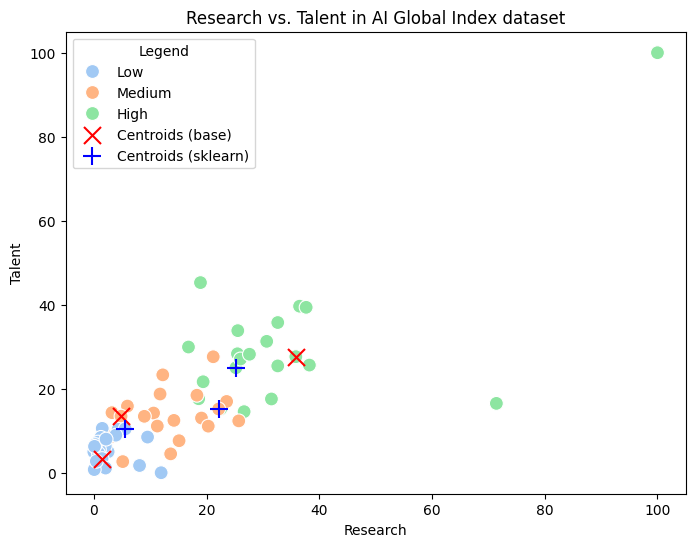

In [12]:
research_idx = list(ai_filtered.columns).index("Research")
talent_idx = list(ai_filtered.columns).index("Talent")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette="pastel", s=100)
plt.scatter(centroids_base_ai[:, research_idx], centroids_base_ai[:, talent_idx], c='red', marker='x', s=150, label='Centroids (base)')
plt.scatter(centroids_sklearn_ai[:, research_idx], centroids_sklearn_ai[:, talent_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

plt.xlabel("Research")
plt.ylabel("Talent")
plt.title("Research vs. Talent in AI Global Index dataset")
plt.legend(title="Legend")
plt.show()

In [13]:
from sklearn.preprocessing import OrdinalEncoder

path = kagglehub.dataset_download("shreyasur965/recent-earthquakes")
earthquakes = pd.read_csv(os.path.join(path, "earthquakes.csv"))

earthquakes = earthquakes.drop(columns=["id", "type", "title", "date", "time", "updated", "url",
                                        "detailUrl", "status", "net", "code", "ids", "sources",
                                        "types", "geometryType", "place", "placeOnly", "location", "subnational", "city",
                                        "locality", "postcode", "what3words", "timezone", "locationDetails", "continent", "country"])

earthquakes = earthquakes.dropna()
earthquakes_filtered = earthquakes.drop(columns=['alert'])

encoder = OrdinalEncoder()

categorical_cols = [col for col in earthquakes_filtered.columns if earthquakes_filtered[col].dtype not in [np.int64, np.float64]]
earthquakes_filtered[categorical_cols] = encoder.fit_transform(earthquakes_filtered[categorical_cols])

X_earth = earthquakes_filtered.to_numpy()
k_earth = 4

print("Global Earthquake Data")

start_time = time.time()
labels_base_earth, centroids_base_earth = k_medoids(X_earth, k_earth)
print(f"Execution time (base): {time.time() - start_time} seconds")
print(f"DBI score (base): {davies_bouldin_score(X_earth, labels_base_earth)}")

start_time = time.time()
kmedoids_earth = KMedoids(n_clusters=k_earth, random_state=seed).fit(X_earth)
labels_sklearn_earth = kmedoids_earth.labels_
centroids_sklearn_earth = kmedoids_earth.cluster_centers_
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print(f"DBI score (sklearn): {davies_bouldin_score(X_earth, labels_sklearn_earth)}")

100%|██████████| 214k/214k [00:00<00:00, 51.6MB/s]

Extracting files...
Global Earthquake Data


Execution time (base): 0.14402556419372559 seconds
DBI score (base): 1.8054293097756364

Execution time (sklearn): 0.07539629936218262 seconds
DBI score (sklearn): 1.599406452739044


/usr/local/lib/python3.11/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(


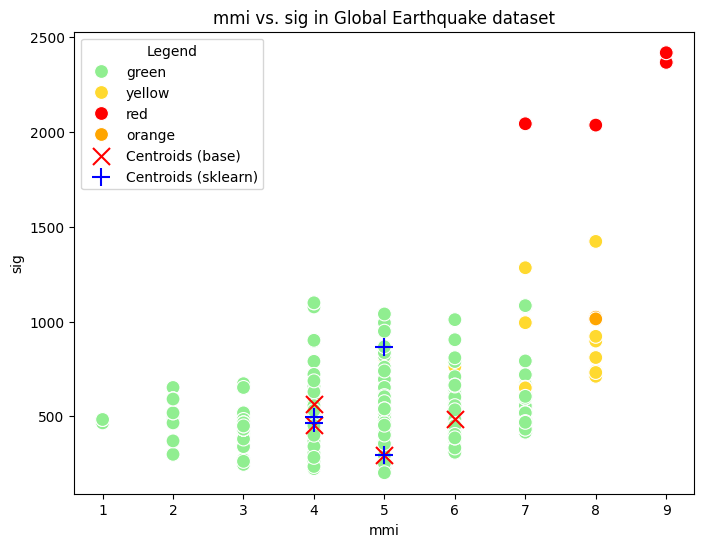

In [16]:
sig_idx = list(earthquakes_filtered.columns).index("sig")
mmi_idx = list(earthquakes_filtered.columns).index("mmi")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue="alert", palette={"green": "lightgreen", "orange": "orange", "red": "red", "yellow": sns.color_palette("Set2")[-3]}, s=100)
plt.scatter(centroids_base_earth[:, mmi_idx], centroids_base_earth[:, sig_idx], c='red', marker='x', s=150, label='Centroids (base)')
plt.scatter(centroids_sklearn_earth[:, mmi_idx], centroids_sklearn_earth[:, sig_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

plt.xlabel("mmi")
plt.ylabel("sig")
plt.title("mmi vs. sig in Global Earthquake dataset")
plt.legend(title="Legend")
plt.show()

In [28]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif

encoder = OrdinalEncoder()

alert_encoded = encoder.fit_transform(earthquakes["alert"].to_frame())
selector = SelectKBest(score_func=mutual_info_classif, k=5)

X_earth = selector.fit_transform(earthquakes_filtered, alert_encoded.ravel())
k_earth = 4

print("Global Earthquake Data")

start_time = time.time()
labels_base_earth, centroids_base_earth = k_medoids(X_earth, k_earth)
print(f"Execution time (base): {time.time() - start_time} seconds")
print(f"DBI score (base): {davies_bouldin_score(X_earth, labels_base_earth)}")

start_time = time.time()
kmedoids_earth = KMedoids(n_clusters=k_earth, random_state=seed).fit(X_earth)
labels_sklearn_earth = kmedoids_earth.labels_
centroids_sklearn_earth = kmedoids_earth.cluster_centers_
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print(f"DBI score (sklearn): {davies_bouldin_score(X_earth, labels_sklearn_earth)}")

Global Earthquake Data
Execution time (base): 0.31393980979919434 seconds
DBI score (base): 0.7949357264074187

Execution time (sklearn): 0.034420013427734375 seconds
DBI score (sklearn): 0.7949357264074187


/usr/local/lib/python3.11/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(


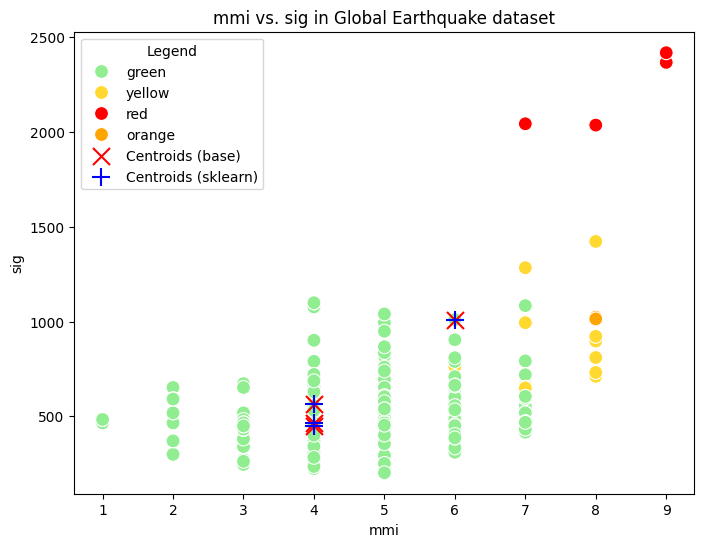

In [29]:
sig_idx = list(earthquakes_filtered.columns[selector.get_support()]).index("sig")
mmi_idx = list(earthquakes_filtered.columns[selector.get_support()]).index("mmi")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue="alert", palette={"green": "lightgreen", "orange": "orange", "red": "red", "yellow": sns.color_palette("Set2")[-3]}, s=100)
plt.scatter(centroids_base_earth[:, mmi_idx], centroids_base_earth[:, sig_idx], c='red', marker='x', s=150, label='Centroids (base)')
plt.scatter(centroids_sklearn_earth[:, mmi_idx], centroids_sklearn_earth[:, sig_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

plt.xlabel("mmi")
plt.ylabel("sig")
plt.title("mmi vs. sig in Global Earthquake dataset")
plt.legend(title="Legend")
plt.show()

In [30]:
scores = selector.scores_
feature_ranking = sorted(zip(earthquakes_filtered.columns, scores), key=lambda x: x[1], reverse=True)
top_features = [f[0] for f in feature_ranking[:5]]
print("Top 5 Features Sorted by Importance:", top_features)

Top 5 Features Sorted by Importance: ['sig', 'mmi', 'longitude', 'latitude', 'magnitude']
